In [1]:
"""Compute Cross Reactivity between two groups of lineage lists"""
from scripts.Compute_FR_SC2 import Compute_FR_SC2
import pandas as pd

"""
Use Hands_On.R to obtain the mutation profiles of JN.1, JN.2, JN.3, KP.3, XBB.1.5
- Compute the symmetrical cross reactivity betweeen the groups 
- Produce cross-reactivity maps figure like Fig. 2C of Manuscript "SARS-CoV2 evolution on a dynamic immune landscape"
  Hint: Use matplotlib package seaborn.heatmap --- 
  Hint: https://github.com/KleistLab/VASIL/blob/main/scripts/plotting/Cross_maps.py
"""

### Here we use the same list of lineages to obtain a symetrical cross-reactivity output
lineage_list_1 = ["X1", "X2", "Y1", "Y2", "EG.5.1"]

mut_dic_1 = { "X1": "data/input/X1_mut.txt",
              "X2": "data/input/X2_mut.txt",
              "Y1":"data/input/Y1_mut.txt",
              "Y2":"data/input/Y2_mut.txt",
              "EG.5.1":"data/input/EG_5_1.txt"
             }

lineage_list_2 = ["X1", "X2", "Y1", "Y2", "EG.5.1"]

mut_dic_2 = { "X1": "data/input/X1_mut.txt",
              "X2": "data/input/X2_mut.txt",
              "Y1":"data/input/Y1_mut.txt",
              "Y2":"data/input/Y2_mut.txt",
              "EG.5.1":"data/input/EG_5_1.txt"
             }


### Compute Cross ###
Cross_dic, epitopes = Compute_FR_SC2(lins_1 = lineage_list_1, 
                                lins_2 = lineage_list_2, 
                                Muts_1 = mut_dic_1,
                                Muts_2 = mut_dic_2,
                                dms_data = "data/dms_per_ab_per_site.csv", 
                                add_WT = False) # add wild-type

### Save results to csv ###
for ab in epitopes:
    Cross_df = pd.DataFrame(Cross_dic[ab], 
                            index = Cross_dic["variant_list1"], 
                            columns = Cross_dic["variant_list2"]) ### dataframes are already aligned
    Cross_df.to_csv("data/output/cross_sim_%s.csv"%ab)
    print("----------------------------------")
    print("Cross reactivity to epitope %s"%ab)
    print(Cross_df)

----------------------------------
Cross reactivity to epitope A
               X1         X2          Y1         Y2      EG.5.1
X1       1.000000   4.315848   26.550694  22.940999   59.795550
X2       4.315848   1.000000   26.834652  22.940999   59.559491
Y1      26.550694  26.834652    1.000000  58.527973  101.368363
Y2      22.940999  22.940999   58.527973   1.000000   59.932025
EG.5.1  59.795550  59.559491  101.368363  59.932025    1.000000
----------------------------------
Cross reactivity to epitope B
                 X1           X2           Y1           Y2       EG.5.1
X1         1.000000   149.338384   232.845595   176.667245  4688.453718
X2       149.338384     1.000000   234.390154   176.667245  4690.166551
Y1       232.845595   234.390154     1.000000   286.578002  4739.496017
Y2       176.667245   176.667245   286.578002     1.000000  4692.064928
EG.5.1  4688.453718  4690.166551  4739.496017  4692.064928     1.000000
----------------------------------
Cross reactivity to

In [2]:
"""Compute Variant Fitness for a tested variant which 
must always be included in lineage_list_1 because of asymetry of the cross reactivity table
"""
from scripts.Fitness_SC2 import Immune_dynamics
import numpy as np
### load pharmacokinetics used : each columns represents a combination of pharamacokinetics parameters ####
PK_dframe = pd.read_csv("data/PK_for_all_Epitopes.csv")

### Drop irrelevant columns
PK_dframe.drop(columns = ["Day since activation", "Unnamed: 0"], inplace = True)

### Potency of Epitope classes ####
potency = {'A': 0.2581345199991067, 'B': 0.15002419850071694, 'C': 0.5961299385766167, 
           'D1': 0.6163901409163847, 'D2': 0.17142504894868016, 'E12': 1.0086135510680292, 
           'E3': 2.4564828793602276, 'F1': 3.0147209112838187, 'F2': 0.8418299673818657, 
           'F3': 0.8862488439645552, 'NTD': 1.0}

IC50xx = 1.5245833433873104
IC50xx_dic = {epitopes[i]:IC50xx*potency[epitopes[i]] for i in range(len(epitopes))}



**Expected sterilizing immunity against variant y**

$$\mathbb{E}[{Immune}_y(t)] = \sum_{x \in \mathcal{X}} \int_{0}^t \pi_x(s) \cdot I(s) \cdot P_{Neut}(t-s, x, y) ds$$
where 
- $\mathcal{X}$ is the group of all variants infection history
- $\pi_x$ is the proportion of variants $x$, 
- $I$ is the infection timeline, 
- and $P_{Neut}$ is the Neutralization probability

**Expected number of susceptible to infection with variant y**

$$\mathbb{E}[S_y(t)] = Pop - \mathbb{E}[Immune_y(t)]$$

In [3]:
"""Project 5: Question 2) Compute number of susceptible for major variants in Germany listed bellow"""

### provide infection data
dfI = pd.read_csv("data/input/test_Germany/infection_data.csv")
infection_data_Germany_orig = dfI["num_infected"].to_numpy()
PopG = 84334787.0 ### total population for Germany


### load dates ###
dates = dfI["Unnamed: 0"].to_list() ### or to_numpy() if you want a numpy array

#### restrict simulation timeframe infection data
start_sim = "2021-07-01"
end_sim = "2024-07-03"

# restict infection timeline
start = dates.index(start_sim)
end = dates.index(end_sim)
infection_data_Germany = infection_data_Germany_orig[start:end+1]
dates = dates[start:end+1]
### provide variant proportion timeline, each row represents the variant corresponding to variants_in_timeline
# NB: if cross-reactivity file is asymetric, variants_in_timeline has to be a subset of lineage_list_2 
# But here it does not matter because we computed a symetrical cross-reactivity
dfProp = pd.read_csv("data/input/test_Germany/variant_proportion.csv")

variants_in_timeline_Germany = dfProp["Unnamed: 0"].to_list()

#remove irrelevant column
dfProp.drop(columns = ["Unnamed: 0"], inplace = True)
date_prop = dfProp.columns.to_list()
start1 = date_prop.index(start_sim)
end1 = date_prop.index(end_sim)
variant_proportion_Germany = dfProp.to_numpy()[:, start1:end1+1] # rows corresponds to variants and columns to timepoints 


### load Cross reactivity dictionary (already given in dataset) ####
import pickle
file = open("data/input/test_Germany/Cross_react_Germany.pck", "rb")
Cross_dic_Germany= pickle.load(file)
file.close()


### Choose one of the 75 combination of pharmacokinetics parameter
PK_params = list(PK_dframe.columns)
ind = 1 ### as  an example
PK_trend = PK_dframe[PK_params[ind]].to_numpy()

### compute expected number of immunized for example for BA.2
BA2 = "BA.2"
Exp_I_BA2 = Immune_dynamics(PK_trend, 
                            infection_data_Germany, 
                            tested_variant = BA2, 
                            variants_in_timeline = variants_in_timeline_Germany, 
                            variant_proportion = variant_proportion_Germany, 
                            Ab_classes = epitopes,      
                            IC50xx_dic = IC50xx_dic, 
                            Cross_react_dic = Cross_dic_Germany)


### Compare fitnesses
Exp_SuscBA2 = PopG - Exp_I_BA2
print("Simulation for %s"%PK_params[ind])
print("Expected Susceptible for %s"%BA2, Exp_SuscBA2)

Simulation for t_half = 25.000 
t_max = 17.500
Expected Susceptible for BA.2 [84334058.82364297 84332773.5306095  84331052.75380486 ...
 83126286.00243422 83112019.10971667 83097235.37699068]


**Relative number of Susceptible to variant y**

$$\gamma_y(t) = \dfrac{\mathbb{E}[S_y(t)] - \sum_{x\in \mathcal{X}} \pi_x(t) \cdot \mathbb{E}[S_x(t)]}{\sum_{x\in \mathcal{X}} \pi_x(t) \cdot \mathbb{E}[S_x(t)]}$$

In [4]:
"""Evaluate relative number of Susceptible"""

def gamma_y(S, pS_mean):
    return np.divide(S - pS_mean, pS_mean, out = np.zeros(len(S)), where = pS_mean != 0.)

### compute S_timeline, the vector containing the expected number of susceptible fo
S_timeline_Germany = []

for i in range(len(variants_in_timeline_Germany)):
    Ei = Immune_dynamics(PK_trend, 
                infection_data_Germany, 
                tested_variant = variants_in_timeline_Germany[i], ### here compute for variants that are in timeline 
                variants_in_timeline = variants_in_timeline_Germany, 
                variant_proportion = variant_proportion_Germany, 
                Ab_classes = epitopes,      
                IC50xx_dic = IC50xx_dic, 
                Cross_react_dic = Cross_dic_Germany)
    
    Res = PopG - Ei
    S_timeline_Germany.append(Res)
    
pS_mean = np.sum(variant_proportion_Germany*np.array(S_timeline_Germany), axis = 0)

### compute gamma for BA2
gBA2 = gamma_y(Exp_SuscBA2,pS_mean)

### Compare relative fitnesses
print("Simulation for %s"%PK_params[ind])
print("Relative fitness for %s"%BA2, gBA2)

Simulation for t_half = 25.000 
t_max = 17.500
Relative fitness for BA.2 [5.15023245e-05 1.09053209e-04 1.60106120e-04 ... 1.91126245e-02
 1.94354182e-02 1.97616934e-02]


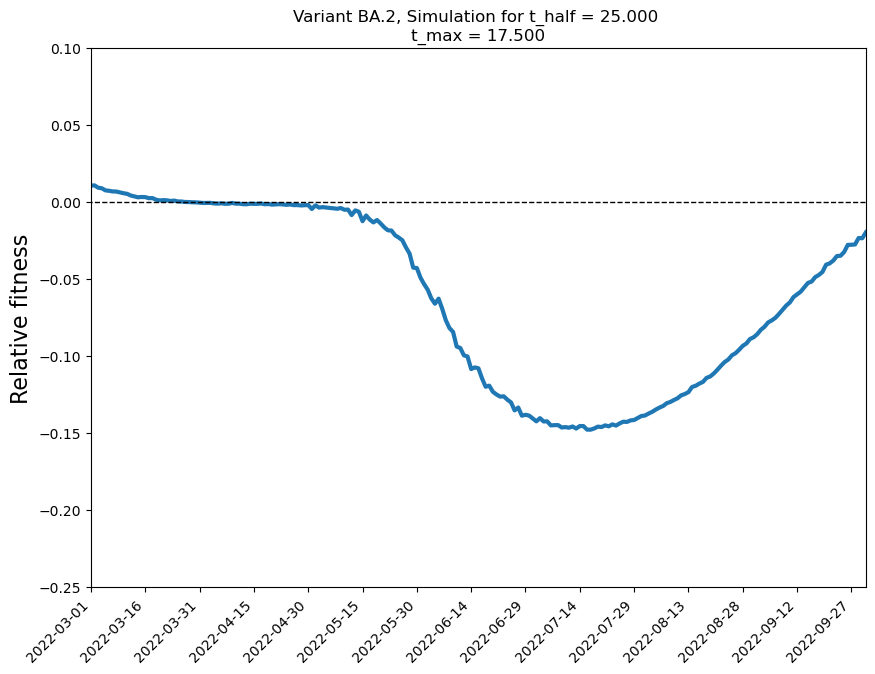

In [5]:
### plotting
from matplotlib import pyplot as plt
fig = plt.figure(figsize = (10, 7))
ax = fig.add_subplot(1, 1, 1)
t = np.arange(len(dates))
xmin, xmax = dates.index("2022-03-01"), dates.index("2022-10-01")
plt.plot(t[xmin:xmax+1], gBA2[xmin:xmax+1], linewidth = 3)
plt.plot(t, np.zeros(len(t)), ls = "--", color = "black", linewidth = 1)
ax.set_xticks(t[xmin:xmax][::15])
ax.set_xticklabels(dates[xmin:xmax][::15], rotation = 45, horizontalalignment = "right")
plt.title("Variant %s, Simulation for %s"%(BA2,PK_params[ind]))
plt.ylabel("Relative fitness", fontsize = 16)
plt.ylim((-0.25, 0.1))
plt.xlim((xmin, xmax))
plt.show()